In [51]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(concat_path("song", "[분석용]pop_music.mid"), True)
base_midi

<music21.stream.Score 0x21f178fdcd0>

In [52]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Piano
Guitar
Bass
Strings


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


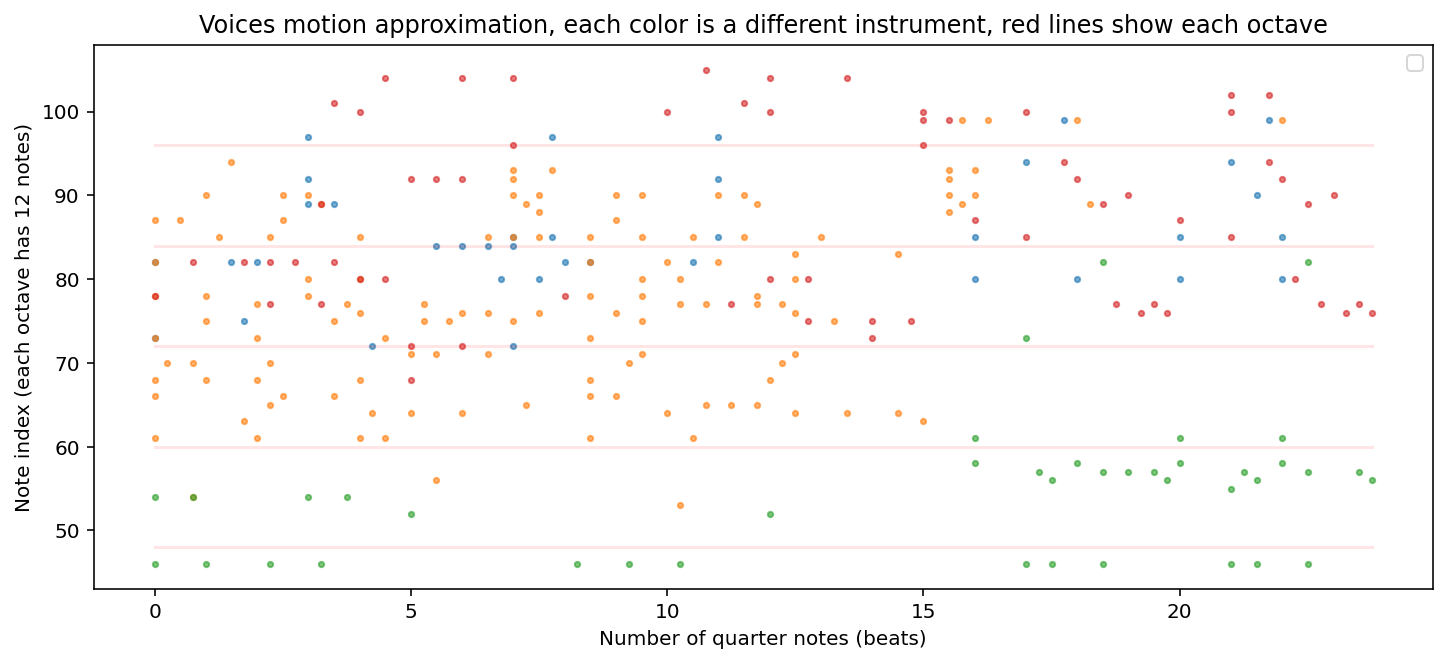

In [66]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.legend()
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

## 빨간선은 피아노 음계의 옥타브를 표현하고 옥타브 사이에 12음계(흰/검은 건반)가 있다고 생각하면 된다. 각 다른 악기들은 pitch note가 다른 색깔로 표현되어 있다.

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x21f178fdcd0>>

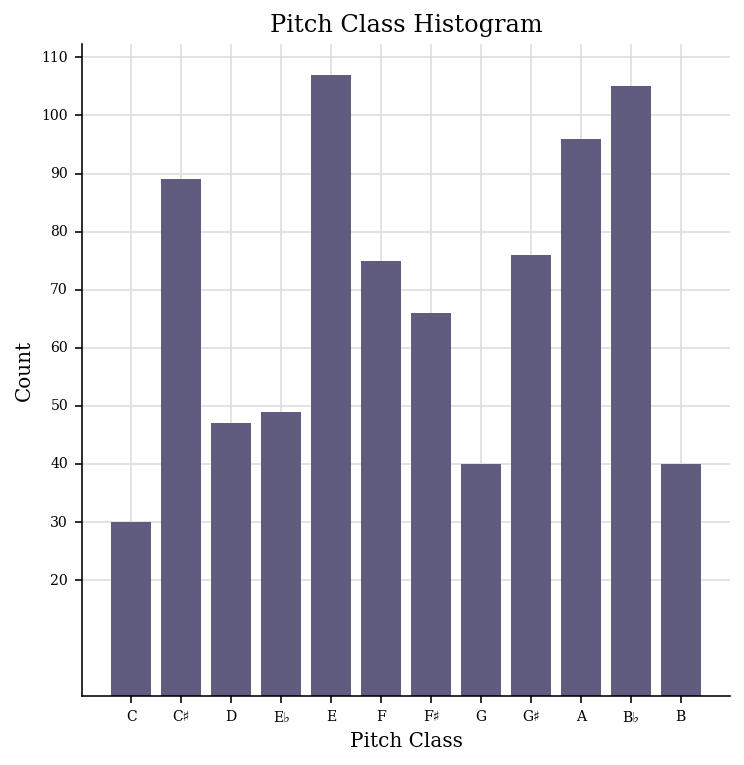

In [54]:
base_midi.plot('histogram', 'pitchClass', 'count')

### The scatter plot shows that the use of notes look consistent through time, so there are no key changes in this piece. 시간에 따른 pitch class 분포를 찍어보고 중간에 조성이 바뀌는 곡인지 아닌지 확인해본다.

<music21.graph.plot.ScatterPitchClassOffset for <music21.stream.Score 0x21f178fdcd0>>

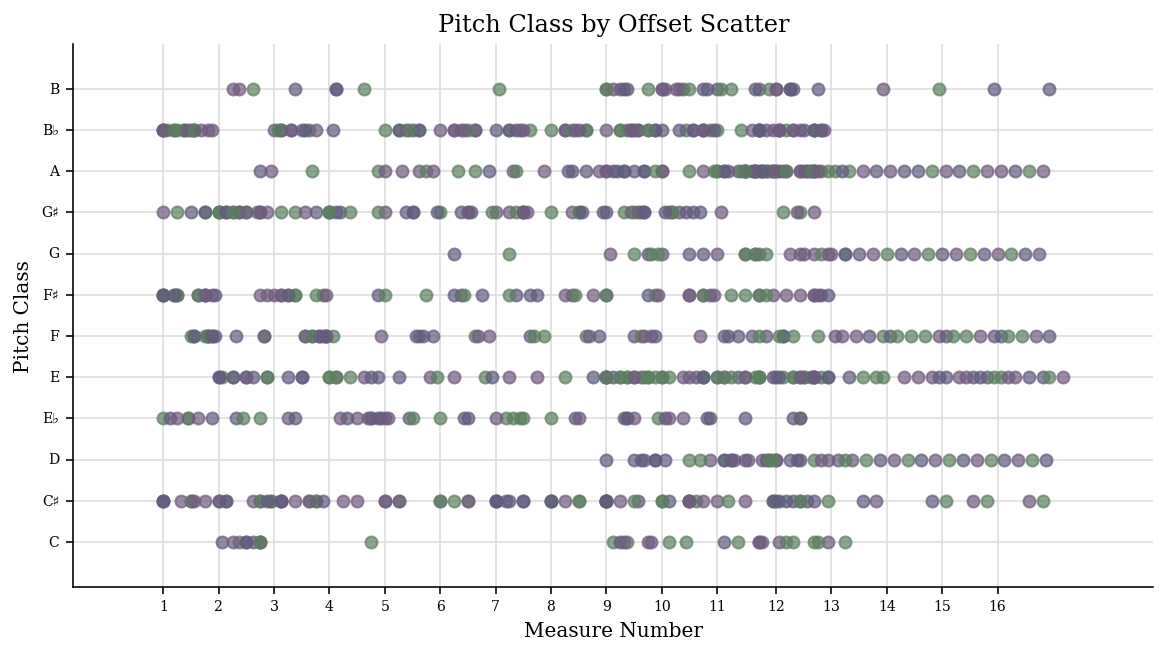

In [55]:
base_midi.plot('scatter', 'offset', 'pitchClass')

### 이번에는 histogram이 아니라 라이브러리를 이용하여 곡의 박자와 조성을 읽어온다. (4/4박자, A minor Key)

In [56]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: A major
Music key confidence: 0.6224231994498645
Other music key alternatives:
c# minor


In [57]:
music_analysis.alternateInterpretations

[<music21.key.Key of c# minor>,
 <music21.key.Key of E major>,
 <music21.key.Key of f# minor>,
 <music21.key.Key of F# major>,
 <music21.key.Key of g# minor>,
 <music21.key.Key of B major>,
 <music21.key.Key of b minor>,
 <music21.key.Key of C# major>,
 <music21.key.Key of e- minor>,
 <music21.key.Key of D major>,
 <music21.key.Key of e minor>,
 <music21.key.Key of b- minor>,
 <music21.key.Key of a minor>,
 <music21.key.Key of d minor>,
 <music21.key.Key of A- major>,
 <music21.key.Key of C major>,
 <music21.key.Key of f minor>,
 <music21.key.Key of E- major>,
 <music21.key.Key of F major>,
 <music21.key.Key of G major>,
 <music21.key.Key of g minor>,
 <music21.key.Key of B- major>,
 <music21.key.Key of c minor>]

## Harmonic Reduction
### 곡의 분석을 용이하게 하기 위해 music reduction을 수행한다. Music reduction이란 곡의 변형, 복잡한 리듬, block chord 등을 배제하여 곡의 복잡도를 줄이는 것이다. Citing the wikipedia explanation about this)

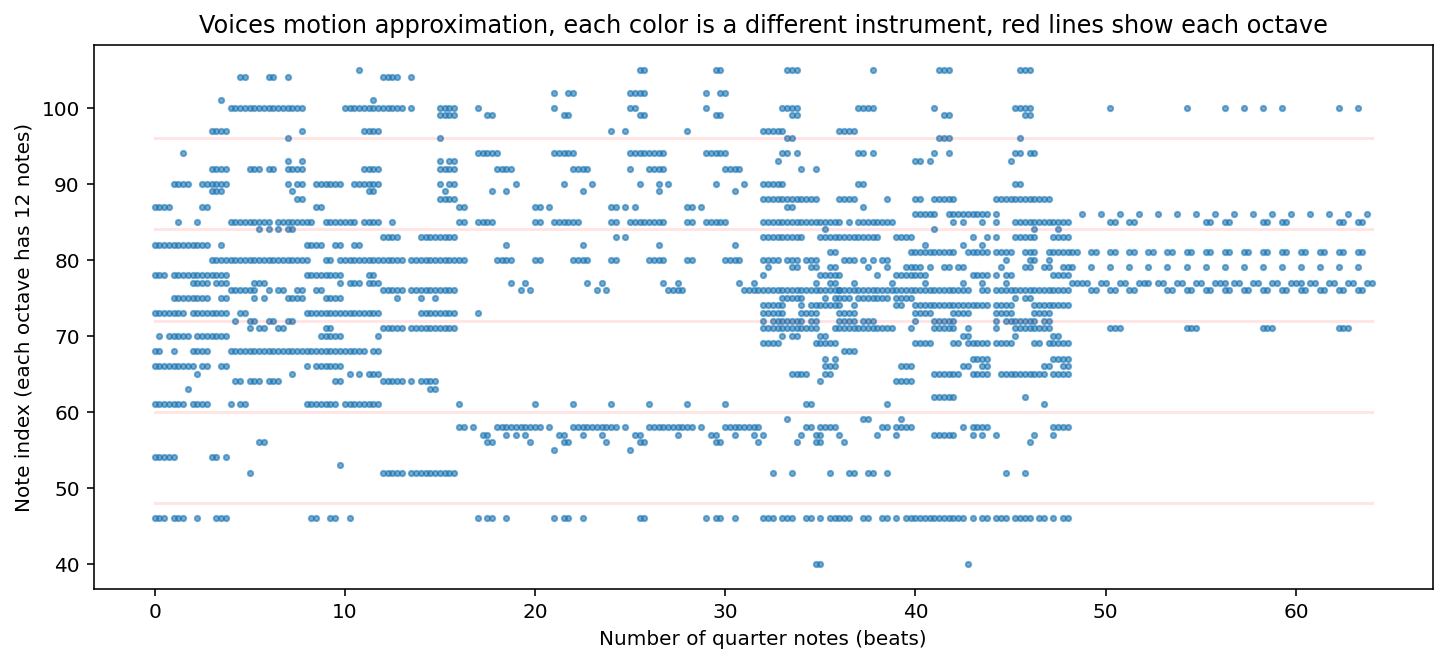

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Piano: Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark andantino Quarter=80.0>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord B-2 F#3 C#4 F#4 G#4 C#5 F#5 B-5 E-6>
    {0.25} <music21.chord.Chord B-2 F#3 C#4 F#4 G#4 B-4 C#5 F#5 B-5 E-6>
    {0.5} <music21.chord.Chord B-2 F#3 C#4 F#4 C#5 F#5 B-5 E-6>
    {0.75} <music21.chord.Chord F#3 C#4 F#4 B-4 C#5 B-5 E-6>
    {1.0} <music21.chord.Chord B-2 F#3 C#4 F#4 G#4 B-4 C#5 E-5 F#5 B-5 F#6>
    {1.25} <music21.chord.Chord B-2 C#4 F#4 B-4 C#5 E-5 F#5 B-5 C#6 F#6>
    {1.5} <music21.chord.Chord B-2 C#4 F#4 B-4 C#5 E-5 F#5 B-5 F#6 B-6>
    {1.75} <music21.chord.Chord E-4 F#4 B-4 E-5 F#5 B-5 F#6>
    {2.0} <music21.chord.Chord C#4 F#4 G#4 C#5 E-5 F5 F#5 B-5>
    {2.25} <music21.chord.Chord B-2 C#4 F4 G#4 B-4 C#5 E-5 F5 F#5 B-5 C#6>
    {2.5} <music21.chord.Chord C#4 F#4 G#4 B-4 C#5 E-5 F5 F#5 B-5 E-6 F#6>


<Figure size 432x288 with 0 Axes>

In [58]:
from music21 import stream

temp_midi_chords = open_midi(
    concat_path('song', "[분석용]pop_music.mid"),
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")

### 각 악기의 음역대나 표현하고 있는 부분이 다르기 때문에 여러 코드가 섞여 있다. 따라서 각 마디에 해당하는 대표 코드를 표시하기 위해 제일 많이 쓰이는 4개의 음정을 추출하여 코드로 표현한다. 만약 대표 음정이 (E4, G4, C5, G5)로 정해지면 C-major 코드로 추정. (음정 옆의 숫자는 옥타브를 의미한다) First inversion